In [1]:
# general os
import os
import zipfile
import urllib.request

# numpy
import numpy as np

# specviz
import jdaviz 
from jdaviz import Specviz

# astropy
import astropy # again for the version number
import astropy.units as u
from astropy.io import fits, ascii
from astropy.utils.data import download_file
from astropy.modeling.models import Linear1D, Polynomial1D, Chebyshev1D
from astropy.nddata import StdDevUncertainty
from astropy.visualization import quantity_support

# specutils
import specutils # again for the version number
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.analysis import correlation
from specutils.analysis import template_comparison
from specutils.manipulation import LinearInterpolatedResampler
from specutils.manipulation import extract_region


# matplotlib 
from matplotlib import pyplot as plt


Information about the galaxy $\href{https://skyserver.sdss.org/dr18/VisualTools/explore/summary?ra=179.689293428393&dec=-0.454379058425512}{here}$

In [2]:
spectrum_file = download_file('http://dr18.sdss.org/sas/dr18/spectro/sdss/redux/26/spectra/lite/0285/spec-0285-51930-0184.fits', cache=True )
fn_template = download_file('https://stsci.box.com/shared/static/3rkurzwl0l79j70ddemxafhpln7ljle7.dat', cache=True)

In [3]:
# Look at spectrum
specviz = Specviz()
specviz.load_spectrum(spectrum_file)
specviz.show()

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

In [4]:
spec_unit = u.erg / (u.s * u.cm**2 * u.AA)

# Read spectrum with the ascii function
template = ascii.read(fn_template)
# Create Spectrum1D object
template = Spectrum1D(spectral_axis=template['col1']*u.AA, 
                      flux=template['col2']*spec_unit)

In [5]:
# Cut to useful range - template and obs MUST overlap
use_tmp = (template.spectral_axis.value > 4000) & (template.spectral_axis.value < 9000)
template_cut = Spectrum1D(spectral_axis=template.spectral_axis[use_tmp], flux=template.flux[use_tmp])

In [6]:
# Subtract continuum
mask_temp = (#(template_cut.spectral_axis.value > 3100) & (template_cut.spectral_axis.value < 3700) |
             (template_cut.spectral_axis.value > 4000) & (template_cut.spectral_axis.value < 4700) |
             (template_cut.spectral_axis.value > 5200) & (template_cut.spectral_axis.value < 6200) |
             (template_cut.spectral_axis.value > 7000) & (template_cut.spectral_axis.value < 10500))

template_forcont = Spectrum1D(spectral_axis=template_cut.spectral_axis[mask_temp], flux=template_cut.flux[mask_temp])

# Use fit_generic_continuum
fit_temp = fit_generic_continuum(template_forcont, model=Polynomial1D(5))
cont_temp = fit_temp(template_cut.spectral_axis)
template_sub = template_cut - cont_temp

In [7]:
# Print Spectrum1D object
print(template_sub)

Spectrum1D (length=5366)
flux:             [ 1.6001e+05 erg / (Angstrom cm2 s), ..., -7.2526e+04 erg / (Angstrom cm2 s) ],  mean=1.1387e+04 erg / (Angstrom cm2 s)
spectral axis:    [ 4000.4 Angstrom, ..., 8999.0 Angstrom ],  mean=6441.6 Angstrom


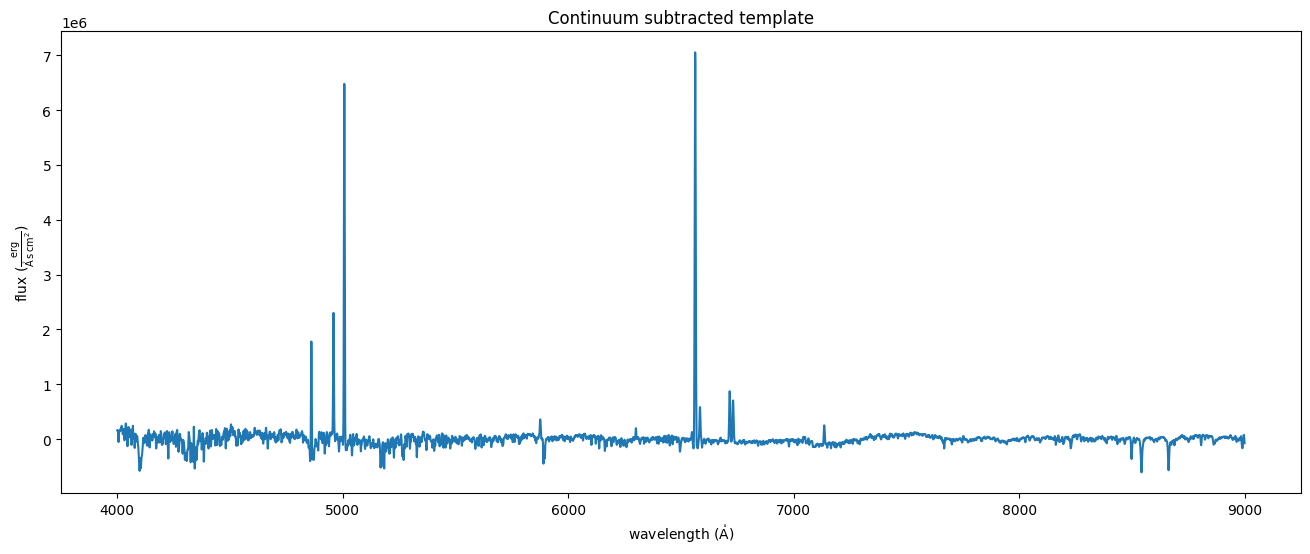

In [8]:
# Look at spectrum
plt.figure(figsize=[16, 6])
plt.plot(template_sub.spectral_axis, template_sub.flux)
plt.xlabel("wavelength ({:latex})".format(template_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(template_sub.flux.unit))
plt.title("Continuum subtracted template")
plt.show()

In [9]:
spectrum_file = Spectrum1D.read(spectrum_file)
# Add the uncertainty
spectrum_file = Spectrum1D(spectral_axis=spectrum_file.spectral_axis, flux=spectrum_file.flux, 
                    uncertainty=StdDevUncertainty(0.05*(spectrum_file.flux)))

print(spectrum_file)

# Define Spectral Region
region = SpectralRegion(4000*u.AA, 9000*u.AA)
# Extract region
spec1d_cont = extract_region(spectrum_file, region)
# Run fitting function
fit_obs = fit_generic_continuum(spec1d_cont, model=Linear1D(5))
# Apply to spectral axis
cont_obs = fit_obs(spectrum_file.spectral_axis)

# Subtract continuum
spec1d_sub = spectrum_file - cont_obs

Spectrum1D (length=3839)
flux:             [ 4.9726 1e-17 erg / (Angstrom cm2 s), ..., 12.533 1e-17 erg / (Angstrom cm2 s) ],  mean=11.088 1e-17 erg / (Angstrom cm2 s)
spectral axis:    [ 3801.0 Angstrom, ..., 9198.1 Angstrom ],  mean=6107.3 Angstrom
uncertainty:      [ StdDevUncertainty(0.24862836), ..., StdDevUncertainty(0.62664694) ]


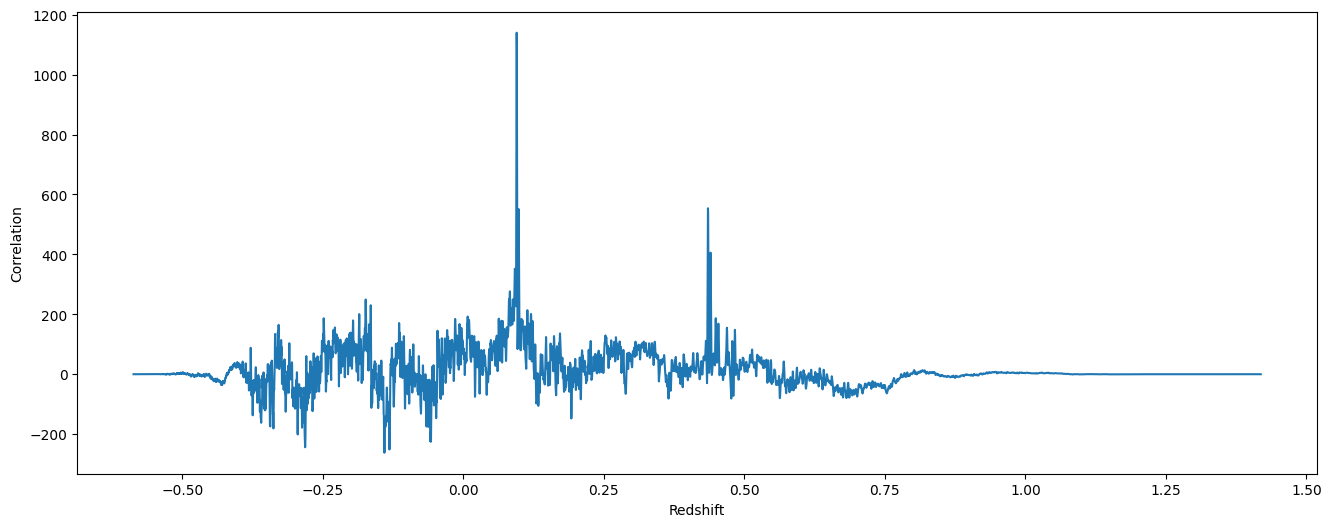

In [10]:
# Call the function
corr, lag = correlation.template_correlate(spec1d_sub, template_sub, lag_units=u.one)

# Plot the correlation
plt.figure(figsize=[16, 6])
plt.plot(lag, corr)
plt.xlabel("Redshift")
plt.ylabel("Correlation")
plt.show()

In [11]:
# Redshift based on maximum
index_peak = np.argmax(corr)
z = lag[index_peak]

print(z)

0.09506670635536962


In [12]:
# Download the library and unzip
boxlink = 'https://stsci.box.com/shared/static/1d68n0cg38it7ja3rgyvv8gxjezdqjgh.zip'
boxfile = './templates.zip'
urllib.request.urlretrieve(boxlink, boxfile)

zf = zipfile.ZipFile(boxfile, 'r')
zf.extractall()

templatedir = './templates/'

In [13]:
# Create the list of Spectrum1Ds for the templates
templatelist = []
for i in range(1, 100):
    template_file = "{0}{1:05d}.dat".format(templatedir, i)
    template = ascii.read(template_file)
    temp1d = Spectrum1D(spectral_axis=template['col1']*u.AA, flux=template['col2']*spec_unit)
    templatelist.append(temp1d)

In [14]:
zz = 0.09506


# Define the resample method
resample_method = "flux_conserving"

# Run the function
tm_results = template_comparison.template_match(observed_spectrum=spectrum_file, 
                                                spectral_templates=templatelist, 
                                                resample_method=resample_method, 
                                                redshift=zz) # Change the redshift variable for list or fixed

In [15]:
# Print results
print(tm_results)

(<Spectrum1D(flux=<Quantity [0.        , 0.        , 0.        , ..., 0.038056  , 0.03779354,
           0.03739986] 1e-17 erg / (Angstrom cm2 s)>, spectral_axis=<SpectralAxis [   110.272542,    111.258096,    112.24365 , ..., 106220.82    ,
   106658.844   , 107096.868   ] Angstrom>)>, 0.09506, 60, 687874.5732298692, [[1007077.0180551268], [1058416.9743165525], [1098629.0752249898], [1429311.7032093133], [1195157.0572066011], [900081.481568236], [1319517.2466284488], [1226546.1933448527], [1341677.2911741855], [1056155.2341124243], [1176072.1841505542], [1168278.118471249], [1014985.0751190997], [1226539.030877365], [1275972.2976395423], [1192076.2136342837], [1193483.8952058556], [1078388.4512518845], [1029793.7878369502], [1316084.9278108724], [949215.710519243], [1060474.688811567], [1082449.7913646789], [988285.4165728652], [929042.700542426], [1189808.539321817], [1378381.6132413566], [765192.3274014031], [1075767.6639620434], [1116611.7117773215], [1165831.97399042], [1070795.38

In [16]:
viz2 = Specviz()
viz2.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

In [18]:
viz2.load_spectrum(spectrum_file, data_label='Observed spectrum')
viz2.load_spectrum(tm_results[0], data_label='Redshifted best template')